<a href="https://colab.research.google.com/github/markpoxley/rrVAE-for-4D-STEM/blob/main/4D_STEM_rrVAE_SIMULATIONSV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

June 13, 2020

rVAE analysis of the simulated 4D STEM data. Here, we aim to explore if rVAE can be used to map the rotational symmetries within 4D STEM. 

- the original data analysis and workflow by Rama Vasudevan and MArk Oxley
- the rVAE by Maxim Ziatdinov
- workflow by Sergei V. Kalinin
- notebook built upon the ReadHDFheaderABS.ipynb by Rama and Mark, and rVAE from Maxim

June 16. Some observations:
- works like a charm after average subtrastion (keep in mind for future)
- we can explore the correlation of the latent variables and offsets with the classical com_x, com_y, and average
- by physics of the problem, I think we need to explore the simpler network where offsets are fixed to 0, and we consider only simple rotations. (Comment June 17 - not really. It's still latent

Action plan to make it a paper:
- Maxim writes the rrVAE (rotation only), possibly as one subclass of rVAE (other being oVAE where only offsets change)
- Mark provides gdown object for the experimental data. Ideally ASAP. Si/Gr, ferroelectrics?
- Mark, what other descriptors people use for 4D STEM?

June 19. Added rrVAE, developed by Maxim Ziatdinov specifically for this project.

June 13, 2020

Original notebook by Mark/Rama

June 29, 2020

Cleaned up rrVAE code for simulated 4D STEM data

May 9, 2021

*   Added latest version of atomai for consistency
*   Added explanitory remarks





Install atomai

In [ ]:
!pip install -q atomai

Import required libraries to read in and visualize the CBED patterns

In [ ]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import ndimage

Connect to Google drive if for output if desired

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

gdowns for simulated data

Coherent graphene simulation

In [ ]:
!gdown https://drive.google.com/uc?id=1Bw4IlnbXCQnPqgVyxtNhCYaAkkoT74Zn

Downloading...
From: https://drive.google.com/uc?id=1Bw4IlnbXCQnPqgVyxtNhCYaAkkoT74Zn
To: /content/C6_SQ_A32_df=0.00_R1.h5
88.1MB [00:00, 91.1MB/s]


Incoherent Graphene simulation

In [ ]:
!gdown https://drive.google.com/uc?id=1oW-jlWBzHr_aUtqfcxcJsWx2WDWqUbRu

ZnS simulation

In [ ]:
!gdown https://drive.google.com/uc?id=1dudHmAqG1lSc31F2hZyw_JUWrLk5ydLf

Read in simulated CBED patterns and simulation parameters

In [ ]:
filein = 'C6_SQ_A32_df=0.00_R1.h5'
f = h5py.File(filein, 'r')

In [ ]:
# list groups to ensure this file is compatible
list(f.keys())

['CBEDs', 'Calculation', 'Crystal', 'Microscope']

In [ ]:
# Now read in the information required for COM calculation
grp = f['/Crystal']
a0 = np.array(3)
a0 = grp.attrs.get('a0')
grp = f['/Microscope']
ekv = grp.attrs.get('Energy')
grp = f['/Calculation']
nxtile = grp.attrs.get('Nxtile')
nytile = grp.attrs.get('Nytile')
nxsample = grp.attrs.get('Nxsample')
nysample = grp.attrs.get('Nysample')
nopixout = grp.attrs.get('Nopixout')
nopiyout = grp.attrs.get('Nopiyout')

print(' Unit cell size',"% 12.6f" % a0[0],"% 12.6f" % a0[1],"% 12.6f" % a0[2], 'Å' )
print(' The unit cell was tiled ',nxtile,' times in the x-direction and ', nytile, ' times in the y-direction')
print(' The probe was scanned at',nxsample,' positions in the x-direction and ', nysample, ' positions in the y-direction')
print(' The CBEDs were output with ',nopixout,' pixels in the x-direction and ', nopiyout, ' pixels in the y-direction')


 Unit cell size     4.268000     2.464000     2.000000 Å
 The unit cell was tiled  12  times in the x-direction and  20  times in the y-direction
 The probe was scanned at 24  positions in the x-direction and  14  positions in the y-direction
 The CBEDs were output with  256  pixels in the x-direction and  256  pixels in the y-direction


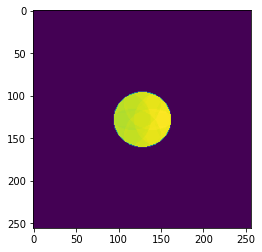

In [ ]:
#lets check what a CBED looks like



dset = f['CBEDs']
CBED = np.empty((nopiyout, nopixout))
# read in the nth CBED to se what we have
n = 0
CBED = dset[n*nopiyout:((n+1)*nopiyout),0:nopixout]

plt.imshow(CBED)


Read in full data set

Lets complete the square and make the image a full periodic structure for visualization.

In [ ]:
CBEDS = np.zeros((nysample+1,nxsample+1,nopiyout,nopixout))
count = 0
for y in range(0,nysample):
    for x in range(0,nxsample):
        count = count + 1
        offset = (count-1)*nopiyout
        CBEDS[y,x,:,:] = dset[offset:offset+nopiyout,0:nopixout]

CBEDS[nysample,:,:,:] = CBEDS[0,:,:,:]
CBEDS[:,nxsample,:,:] = CBEDS[:,0,:,:]

nysample = nysample + 1
nxsample = nxsample + 1

# Center of Mass

Calculate the wavelength of the incident electron

In [ ]:
import math
# First calculate the corresponding wavevector 
# some constants
c1 = 9.7846113e-07
c2 = 12.263868

Eev = 1000.0*ekv
#this is the wavevector
wavev = math.sqrt( Eev + c1*Eev**2.0)/c2


Center of Mass function

In [ ]:
def COM(nysamp, nxsamp, nypix, nxpix, duin, dvin,CBED_in):
    from scipy import ndimage
    import math
    
    com_mag = np.zeros((nysamp, nxsamp))
    com_y = np.zeros((nysamp, nxsamp))
    com_x = np.zeros((nysamp, nxsamp))
    angle = np.zeros((nysamp, nxsamp))
    xyzero = np.zeros(2)
    xyzero = ndimage.measurements.center_of_mass(np.mean(CBED_in, axis=(0,1)) )   
#    xyzero[0] = nypix/2
#    xyzero[1] = nxpix/2
    
    for y in range(nysamp):
        for x in range(nxsamp):
            xycbed = ndimage.measurements.center_of_mass(CBED_in[y,x,:,:])
            com_x[y,x] = (xycbed[1]-xyzero[1])*duin
            com_y[y,x] = (xycbed[0]-xyzero[0])*dvin
            com_mag[y,x] = math.sqrt(com_y[y,x]*com_y[y,x]+com_x[y,x]*com_x[y,x])  
            
    angle = np.arctan2(com_y,com_x)  
    
    return com_y, com_x, angle, com_mag

Calculate COM

In [ ]:
# deflections in invers Å
du = 1.0/(nxtile*a0[0])
dv = 1.0/(nytile*a0[1])
# Uncomment to convert output to milliradians
#du = 1000.0*du/wavev
#dv = 1000.0*dv/wavev
com_y, com_x, angle, com_mag = COM(nysample, nxsample, nopiyout,nopixout,du,dv,CBEDS)

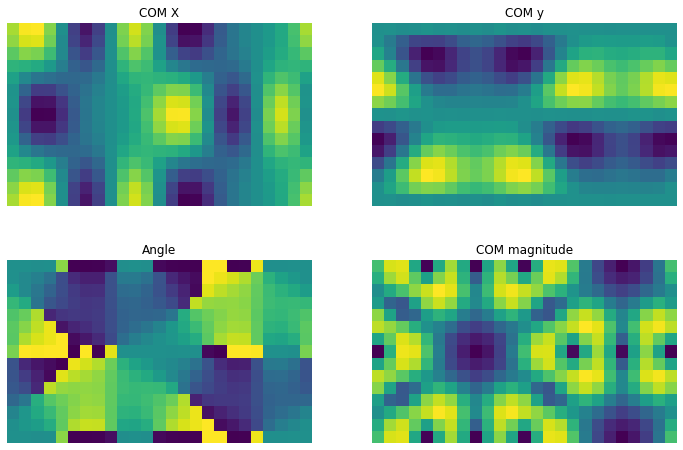

In [ ]:
ncols = 2
nrows = 2
gs2 = gridspec.GridSpec(nrows, ncols)
fig2 = plt.figure(figsize = (12,8))

for i in range(4):
    if i == 0:
        ax2 = fig2.add_subplot(gs2[i])
        ax2.set_title('COM X')
        ax2.imshow(com_x)
        plt.axis('off')
    if i == 1:
        ax2 = fig2.add_subplot(gs2[i])
        ax2.set_title('COM y')
        ax2.imshow(com_y)
        plt.axis('off')
    if i == 2:
        ax2 = fig2.add_subplot(gs2[i])
        ax2.set_title('Angle')
        ax2.imshow(angle)
        plt.axis('off')
    if i == 3:
        ax2 = fig2.add_subplot(gs2[i])
        ax2.set_title('COM magnitude')
        ax2.imshow(com_mag)
        plt.axis('off')
        
    
plt.show()


# Making training set for rrVAE

First lets crop CBED to a smaller size

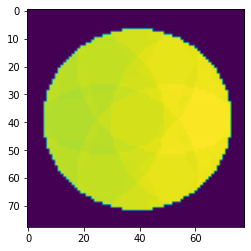

In [ ]:
#check how the objects look like
#First find the COM of the average
xyzero = np.zeros(2)
xyzero = ndimage.measurements.center_of_mass(np.mean(CBEDS, axis=(0,1)) )   

# read in first CBED to set manipulation parameters
CBED = CBEDS[0,0,:,:]

nxcrop = 78
nycrop = 78
nxstart = int(xyzero[1] - nxcrop/2)
nystart = int(xyzero[0] - nycrop/2)
nxstop = nxstart + nxcrop
nystop = nystart + nycrop

plt.imshow(CBED[nystart:nystop,nxstart:nxstop])


In [ ]:
CBED_array = CBEDS[:,:,nystart:nystop,nxstart:nxstop]


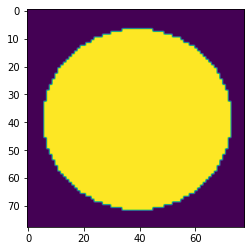

In [ ]:
#create average image and subtract it from descriptor array

CBED_av = np.mean(CBED_array,axis = (0,1))
plt.imshow(CBED_av)
CBED_array = CBED_array-CBED_av

(15, 25, 78, 78)
3.01705632203569e-05 -2.8554332985853163e-05


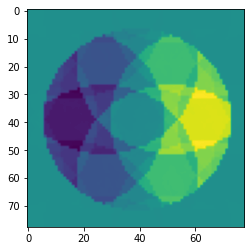

In [ ]:
#check how it looks like and find min/max

print(CBED_array.shape)
CBED_max = CBED_array.max()
CBED_min = CBED_array.min()
print(CBED_max, CBED_min)
plt.imshow(CBED_array[0,0,:,:])

Function to normalize array between 0 and 1

In [ ]:
norm = lambda x: (x - x.min()) / x.ptp()

In [ ]:
#normalize
feature_array = norm(CBED_array.reshape(nysample*nxsample, nycrop, nxcrop))

In [ ]:
# make training/validation sets

from sklearn.model_selection import train_test_split
imstack_train, imstack_test = train_test_split(
    feature_array, test_size=0.15, shuffle=True, random_state=0)
print(imstack_train.shape, imstack_test.shape)

(318, 78, 78) (57, 78, 78)


# rrVAE - rotations only

June 19. Added rrVAE. Specifically developed by Maxim Ziatdinov for this project

In [ ]:
import atomai as aoi
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(0)
np.random.seed(0)

In [ ]:
# Intitialize rVAE model
input_dim = (nycrop, nxcrop)

rrvae = aoi.models.rVAE(input_dim, latent_dim=2,
                        numlayers_encoder=2, numhidden_encoder=128,
                        numlayers_decoder=2, numhidden_decoder=128,
                        skip=False,translation = False) 

In [ ]:
# now train
rrvae.fit(X_train=imstack_train, X_test=imstack_test, training_cycles=1000, batch_size=20, loss="mse")

Epoch: 1/1000, Training loss: 14.6932, Test loss: 16.2040
Epoch: 2/1000, Training loss: 14.9073, Test loss: 15.4825
Epoch: 3/1000, Training loss: 15.0058, Test loss: 15.3142
Epoch: 4/1000, Training loss: 15.1581, Test loss: 16.5706
Epoch: 5/1000, Training loss: 15.1873, Test loss: 14.9307
Epoch: 6/1000, Training loss: 14.8130, Test loss: 17.3999
Epoch: 7/1000, Training loss: 14.9364, Test loss: 17.4373
Epoch: 8/1000, Training loss: 15.1482, Test loss: 16.0345
Epoch: 9/1000, Training loss: 15.0237, Test loss: 14.9441
Epoch: 10/1000, Training loss: 15.1596, Test loss: 16.7773
Epoch: 11/1000, Training loss: 15.1367, Test loss: 15.6647
Epoch: 12/1000, Training loss: 16.6975, Test loss: 16.8128
Epoch: 13/1000, Training loss: 15.9082, Test loss: 16.6393
Epoch: 14/1000, Training loss: 15.2806, Test loss: 15.8223
Epoch: 15/1000, Training loss: 14.8972, Test loss: 16.1816
Epoch: 16/1000, Training loss: 14.9102, Test loss: 15.6336
Epoch: 17/1000, Training loss: 14.6641, Test loss: 16.5043
Epoch:

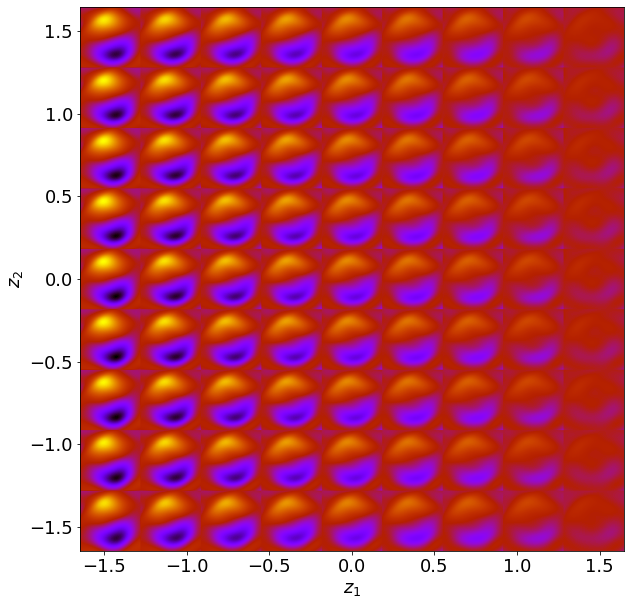

In [ ]:
rrvae.manifold2d(cmap="gnuplot")

In [ ]:
z_mean, z_sd = rrvae.encode(feature_array)

In [ ]:
z_mean.shape

(375, 3)

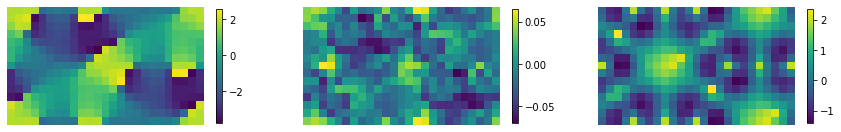

In [ ]:
ncols = 3
nrows = 1
gs2 = gridspec.GridSpec(nrows, ncols)
fig2 = plt.figure(figsize = (15,3.5*nrows))

for i in range(3):
    ax2 = fig2.add_subplot(gs2[i])
    tmp = ax2.imshow(z_mean[:,i].reshape(nysample,nxsample), cmap='viridis')
    fig2.colorbar(tmp, ax = ax2, shrink = 0.6)
    plt.axis('off')
plt.show()
